# Handwriting Recognition
Experiments are performed on the EMNIST dataset (collection of 28x28 pixel images of handwritten letters), and augmented it with collected handwriting of real subjects. The data collection method was simple: random subjects to write on a font conversion template in an iPad, processed their handwritten fonts into `.ttf` files, and then converted all this to match the 28x28 inverted black-white pixels. A variety of classical machine learning methods are shown on this augmented dataset and shown them below.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import struct
import time
from sklearn import neighbors, metrics, cluster, ensemble
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
def read_idx(filename) :
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

### Data Collection and Pre-Processing
This project takes a unique approach to creating the dataset. The data was collected by asking random people to write on a paper with bounding boxes, in which boxes for letters A-Z were shown (for both lowercase and uppercase). This unqiue sheet of paper is powered by [Calligraphr](https://www.calligraphr.com) and here is the [tutorial for converting this into a TTF file](https://www.calligraphr.com/en/docs/tutorial1/). Here's what one collected font looked like:
<div>
<img src="https://i.ibb.co/tMQ2dSW/Final-Project-162.jpg" alt="Final-Project-162" border="0" width=300/>
</div>

The idea is simple; have someone write their unique font on this paper, upload it to the service, and let it convert this into a TTF (true type font) file online. But, now the problem remains how to convert a TTF file into 28x28 grayscale images of each character, resembling the black-white EMNIST format. So, for this, I wrote a script called `ttf_to_png.py` that converts a TTF file into 28x28 grayscale `.png` images:

In [3]:
# Here's ttf_to_png.py:

import sys
import os
import subprocess
import shutil
import glob

from PIL import Image, ImageOps
from fontTools.ttLib import TTFont

# takes ttfs from the source directory and turns them into pngs in the dst_dir
# returns the number of ttfs processed
def convert_ttf(src_dir, dst_dir, force=False, verbose=False):
    DST_DIR = os.path.join(os.getcwd(), dst_dir)
    TEXTS_DIR = os.path.join(DST_DIR, "texts")
    IMAGES_DIR = os.path.join(DST_DIR, "images")
    SRC_DIR = os.path.join(os.getcwd(), src_dir)
    FONT_SIZE = "28"
    
    num_ttfs = len([name for name in os.listdir(SRC_DIR) if name.endswith(".ttf") or name.endswith(".otf")])
    
    # Remove output directories if it exist
    if os.path.exists(DST_DIR):
        if not force:
            num_pngs = len([name for name in os.listdir(DST_DIR) if name.endswith(".png")])
            if num_pngs == num_ttfs * 52:
                print("Images already processed. Exiting conversion")
                return num_ttfs
        shutil.rmtree(DST_DIR)
    os.makedirs(DST_DIR)
    os.makedirs(TEXTS_DIR)
    os.makedirs(IMAGES_DIR)
    #TODO remove dir only if non-full
    
    thumb_width = int(FONT_SIZE)
    # goes through each ttf file
    for file in os.listdir(SRC_DIR):
        if not (file.endswith(".ttf") or file.endswith(".otf")):
            print("Ignored", file)
            continue
        TTF_PATH = os.path.join(SRC_DIR, file)
        TTF_NAME, TTF_EXT = os.path.splitext(os.path.basename(TTF_PATH))
        ttf = TTFont(TTF_PATH)
        # Make temporary directories
        # Writing each individual font character to file as texts
        x = ttf["cmap"].tables[0]
        # for x in ttf["cmap"].tables:
        for y in x.cmap.items():
            char_unicode = chr(y[0])
            char_utf8 = char_unicode.encode('utf_8')
            char_name = y[1]
            if len(char_name) == 1:
                # write each character to a new txt file
                if (char_name >= 'a' and char_name <= 'z') or (char_name >= 'A' and char_name <= 'Z'):
                    upper = char_name.isupper()
                    case = '_upp' if upper else '_low'
                    f = open(os.path.join(TEXTS_DIR, char_name.lower() + case + '.txt'), 'wb')
                    f.write(char_utf8)
                    f.close()
        ttf.close()
        
        # Convert each txt file into a png
        files = os.listdir(TEXTS_DIR)
        for filename in files:
            name, ext = os.path.splitext(filename)
            input_txt = os.path.join(TEXTS_DIR, filename)
            output_png = os.path.join(IMAGES_DIR, TTF_NAME + "_" + name + ".png")
            subprocess.call(["convert", "-font", TTF_PATH, "-pointsize", FONT_SIZE, "label:@" + input_txt, output_png])
        
        # clear out the text directory since we are done with it
        shutil.rmtree(TEXTS_DIR)
        os.makedirs(TEXTS_DIR)

        # Normalizing the images to all be of the correct size
        files = glob.glob(os.path.join(IMAGES_DIR, '*.png'))
        for f in files:
            im = Image.open(f).convert('RGB')
            im = ImageOps.invert(im)
            im_thumb = im.resize((thumb_width, thumb_width), Image.LANCZOS)
            ftitle, fext = os.path.splitext(os.path.basename(f))
            im_thumb.save(os.path.join(DST_DIR, ftitle + fext))

        # done with the image directory
        shutil.rmtree(IMAGES_DIR)
        os.makedirs(IMAGES_DIR)
        if verbose:
          print("Processed", file)
    shutil.rmtree(TEXTS_DIR)
    shutil.rmtree(IMAGES_DIR)
    return num_ttfs

And finally, here's what the resulting images for the above font looks like, concatenated into a grid:
<br>
<br>
<div>
<img src="https://i.ibb.co/KbpP0mD/screencapture-hcrev-github-io-moodboarder-2022-11-21-21-54-58.png" alt="screencapture-hcrev-github-io-moodboarder-2022-11-21-21-54-58" border="0" width=300/>
</div>

In [4]:
# Here's convert_to_mnist_format.py

import numpy
import imageio
import glob
import sys
import os
import random
from PIL import Image

height = 0
width = 0

dstPath = "convert_MNIST"
testLabelPath = dstPath+"/t10k-labels-idx1-ubyte"
testImagePath = dstPath+"/t10k-images-idx3-ubyte"
trainLabelPath = dstPath+"/train-labels-idx1-ubyte"
trainImagePath = dstPath+"/train-images-idx3-ubyte"


def get_subdir(folder):
    listDir = None
    for root, dirs, files in os.walk(folder):
        if not dirs == []:
            listDir = dirs
            break
    listDir.sort()
    return listDir


def get_labels_and_files(folder, number=0):
    # Make a list of lists of files for each label
    filelists = []
    subdir = get_subdir(folder)
    for label in range(0, len(subdir)):
        filelist = []
        filelists.append(filelist)
        dirname = os.path.join(folder, subdir[label])
        for file in os.listdir(dirname):
            if (file.endswith('.png')):
                fullname = os.path.join(dirname, file)
                if (os.path.getsize(fullname) > 0):
                    filelist.append(fullname)
                else:
                    print('file ' + fullname + ' is empty')
        # sort each list of files so they start off in the same order
        # regardless of how the order the OS returns them in
        filelist.sort()

    # Take the specified number of items for each label and
    # build them into an array of (label, filename) pairs
    # Since we seeded the RNG, we should get the same sample each run
    labelsAndFiles = []
    for label in range(0, len(subdir)):
        count = number if number > 0 else len(filelists[label])
        filelist = random.sample(filelists[label], count)
        for filename in filelist:
            labelsAndFiles.append((label, filename))

    return labelsAndFiles


def make_arrays(labelsAndFiles, ratio):
    global height, width
    images = []
    labels = []
    imShape = imageio.imread(labelsAndFiles[0][1]).shape
    print(imShape)
    # if len(imShape) > 2:
    #     height, width, channels = imShape
    #     print(channels)
    # else:
    height, width = imShape[0:2]
    channels = 1
    for i in range(0, len(labelsAndFiles)):
        # display progress, since this can take a while
        if (i % 100 == 0):
            sys.stdout.write("\r%d%% complete" %
                             ((i * 100) / len(labelsAndFiles)))
            sys.stdout.flush()

        filename = labelsAndFiles[i][1]

        img = Image.open(filename)
        new_img = img.convert('1')
        new_img.save(filename)
        

        try:
            image = imageio.imread(filename)
            images.append(image)
            labels.append(labelsAndFiles[i][0])
        except:
            # If this happens we won't have the requested number
            print("\nCan't read image file " + filename)

    if ratio == 'train':
        ratio = 0
    elif ratio == 'test':
        ratio = 1
    else:
        ratio = float(ratio) / 100
    count = len(images)
    trainNum = int(count * (1 - ratio))
    testNum = count - trainNum
    if channels > 1:
        trainImagedata = numpy.zeros(
            (trainNum, height, width, channels), dtype=numpy.uint8)
        testImagedata = numpy.zeros(
            (testNum, height, width, channels), dtype=numpy.uint8)
    else:
        trainImagedata = numpy.zeros(
            (trainNum, height, width), dtype=numpy.uint8)
        testImagedata = numpy.zeros(
            (testNum, height, width), dtype=numpy.uint8)
    trainLabeldata = numpy.zeros(trainNum, dtype=numpy.uint8)
    testLabeldata = numpy.zeros(testNum, dtype=numpy.uint8)

    for i in range(trainNum):
        trainImagedata[i] = images[i]
        trainLabeldata[i] = labels[i]

    for i in range(0, testNum):
        testImagedata[i] = images[trainNum + i]
        testLabeldata[i] = labels[trainNum + i]
    print("\n")
    return trainImagedata, trainLabeldata, testImagedata, testLabeldata


def write_labeldata(labeldata, outputfile):
    header = numpy.array([0x0801, len(labeldata)], dtype='>i4')
    with open(outputfile, "wb") as f:
        f.write(header.tobytes())
        f.write(labeldata.tobytes())

def write_imagedata(imagedata, outputfile):
    global height, width
    header = numpy.array([0x0803, len(imagedata), height, width], dtype='>i4')
    with open(outputfile, "wb") as f:
        f.write(header.tobytes())
        f.write(imagedata.tobytes())


def main(argv):
    global idxLabelPath, idxImagePath
    
    if not os.path.exists(dstPath):
        os.makedirs(dstPath)
    if len(argv) == 3:
        labelsAndFiles = get_labels_and_files(argv[1])
    elif len(argv) == 4:
        labelsAndFiles = get_labels_and_files(argv[1], int(argv[3]))
    random.shuffle(labelsAndFiles)

    trainImagedata, trainLabeldata, testImagedata, testLabeldata = make_arrays(
        labelsAndFiles, argv[2])

    if argv[2] == 'train':
        write_labeldata(trainLabeldata, trainLabelPath)
        write_imagedata(trainImagedata, trainImagePath)
    elif argv[2] == 'test':
        write_labeldata(testLabeldata, testLabelPath)
        write_imagedata(testImagedata, testImagePath)
    else:
        write_labeldata(trainLabeldata, trainLabelPath)
        write_imagedata(trainImagedata, trainImagePath)
        write_labeldata(testLabeldata, testLabelPath)
        write_imagedata(testImagedata, testImagePath)
        
# Uncomment to run
# Usage: python convert_to_mnist_format.py [dataset_dir] num
# where num is the % that will be partitioned into test set randomly
# Example usage: $ python converter.py collected_data 80  

# if __name__ == '__main__':
#     main(sys.argv)

### Dataset Loading

In [5]:
raw_train = read_idx("EMNISTdata/emnist-letters-train-images-idx3-ubyte")
train_data = np.reshape(raw_train, (124800,28*28))
train_label = read_idx("EMNISTdata/emnist-letters-train-labels-idx1-ubyte")

raw_test = read_idx("EMNISTdata/emnist-letters-test-images-idx3-ubyte")
test_data = np.reshape(raw_test, (20800, 28*28))
test_label = read_idx("EMNISTdata/emnist-letters-test-labels-idx1-ubyte")

In [6]:
collected_raw_train = read_idx("convert_MNIST/train-images-idx3-ubyte")
collected_train_data = np.reshape(collected_raw_train, (998,28*28))
collected_train_label = read_idx("convert_MNIST/train-labels-idx1-ubyte")

collected_raw_test = read_idx("convert_MNIST/t10k-images-idx3-ubyte")
collected_test_data = np.reshape(collected_raw_test, (250,28*28))
collected_test_label = read_idx("convert_MNIST/t10k-labels-idx1-ubyte")

In [7]:
combined_raw_train_data = np.concatenate((collected_raw_train, raw_train))
combined_train_data = np.concatenate((collected_train_data,train_data))
combined_train_label = np.concatenate((collected_train_label, train_label))

combined_raw_test_data = np.concatenate((collected_raw_test,raw_test))
combined_test_data = np.concatenate((collected_test_data,test_data))
combined_test_label = np.concatenate((collected_test_label, test_label))

### Decision Trees

### **Must Install GraphViz**
1. Run the command 'brew install graphviz'
1. Find the version number of graphviz with the command 'brew info graphviz'

    ex: Where the * denotes version number

        graphviz: stable *.*.* (bottled)

1. Use the command `export GRAPHVIZ_DIR="/usr/local/Cellar/graphviz/<Version_Number>"` where <Version_Number> is the version number obtained in step 2
1. Run `pip install pygraphviz --global-option=build_ext --global-option="-I$GRAPHVIZ_DIR/include" --global-option="-L$GRAPHVIZ_DIR/lib"`
1. Run `pip install graphviz`

In [8]:
# imports for decision tree

# Standard Libraries
import os
import numpy as np 
import pandas as pd 
import random as rn

# Visualization libraries
import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({"axes.facecolor": ".95"})

# Modeling and Machine Learning
from IPython.display import Image 
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from six import StringIO  
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [9]:
def acc(y_true, y_pred):
    return round(accuracy_score(y_true, y_pred) * 100, 2)

Base MNIST Tree

In [10]:
X = train_data
Y = train_label
X_val = test_data
Y_val = test_label

seed = 117
clf = DecisionTreeClassifier(max_depth=15, random_state=seed)
clf.fit(X, Y)

train_preds_baseline = clf.predict(X)
val_preds_baseline = clf.predict(X_val)
acc_baseline_train = acc(train_preds_baseline, Y)
acc_baseline_val = acc(val_preds_baseline, Y_val)
print(f'Training accuracy for our baseline: {acc_baseline_train}%')
print(f'Validation accuracy for our baseline: {acc_baseline_val}%')

Training accuracy for our baseline: 90.02%
Validation accuracy for our baseline: 71.31%


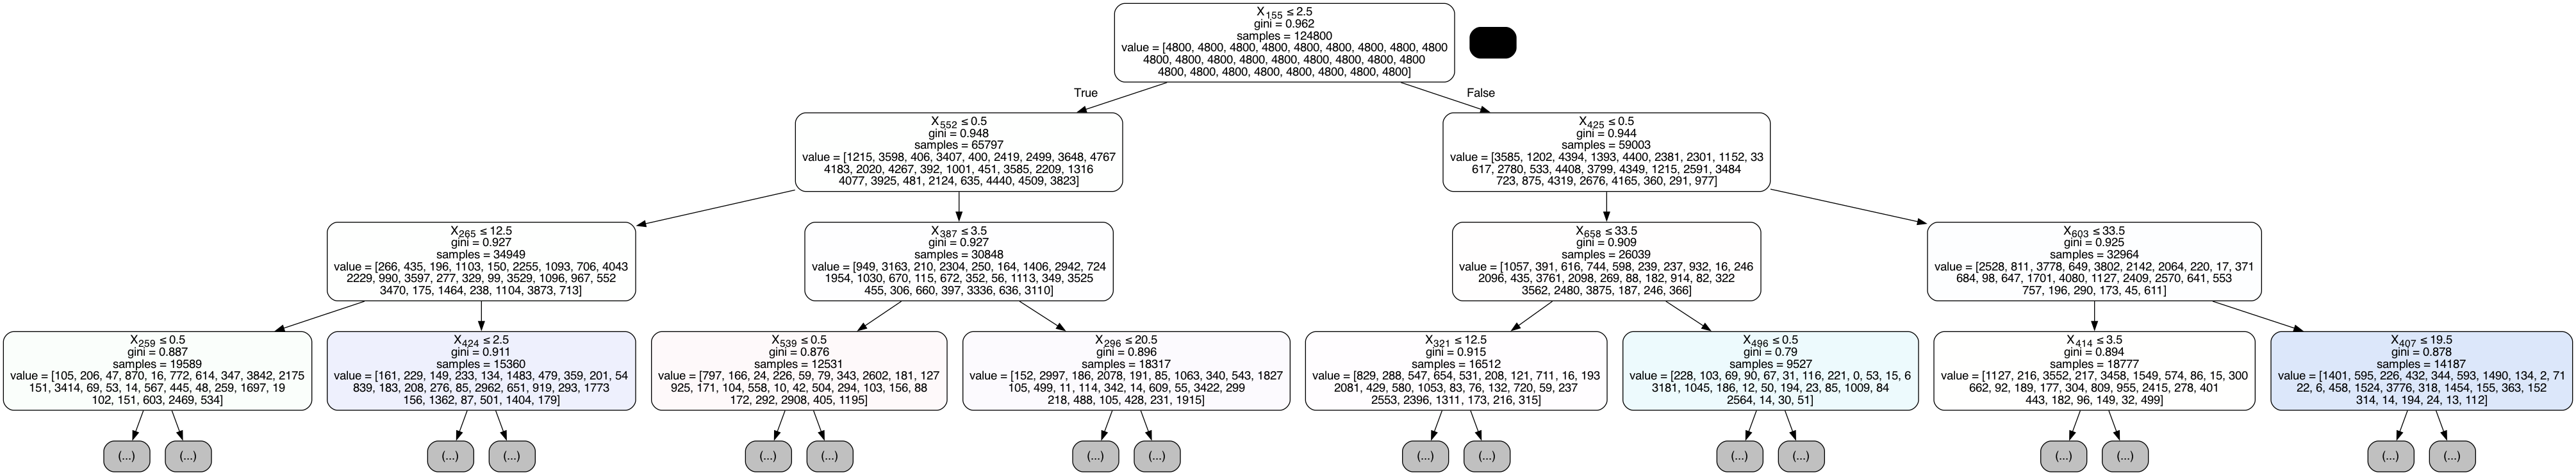

In [11]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"/lib/graphviz"
# Convert Decision Tree to visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

# graph.write_png("mnist_decision_tree_baseline.png")

Collected Data Tree

In [12]:
X_collected = collected_train_data
Y_collected = collected_train_label
X_val_collected = collected_test_data
Y_val_collected = collected_test_label

seed = 117
clf = DecisionTreeClassifier(max_depth=15, random_state=seed)
clf.fit(X_collected, Y_collected)

train_preds_collected = clf.predict(X_collected)
val_preds_collected = clf.predict(X_val_collected)
acc_collected_train = acc(train_preds_collected, Y_collected)
acc_collected_val = acc(val_preds_collected, Y_val_collected)
print(f'Training accuracy for our collected: {acc_collected_train}%')
print(f'Validation accuracy for our collected: {acc_collected_val}%')

Training accuracy for our collected: 94.09%
Validation accuracy for our collected: 17.6%


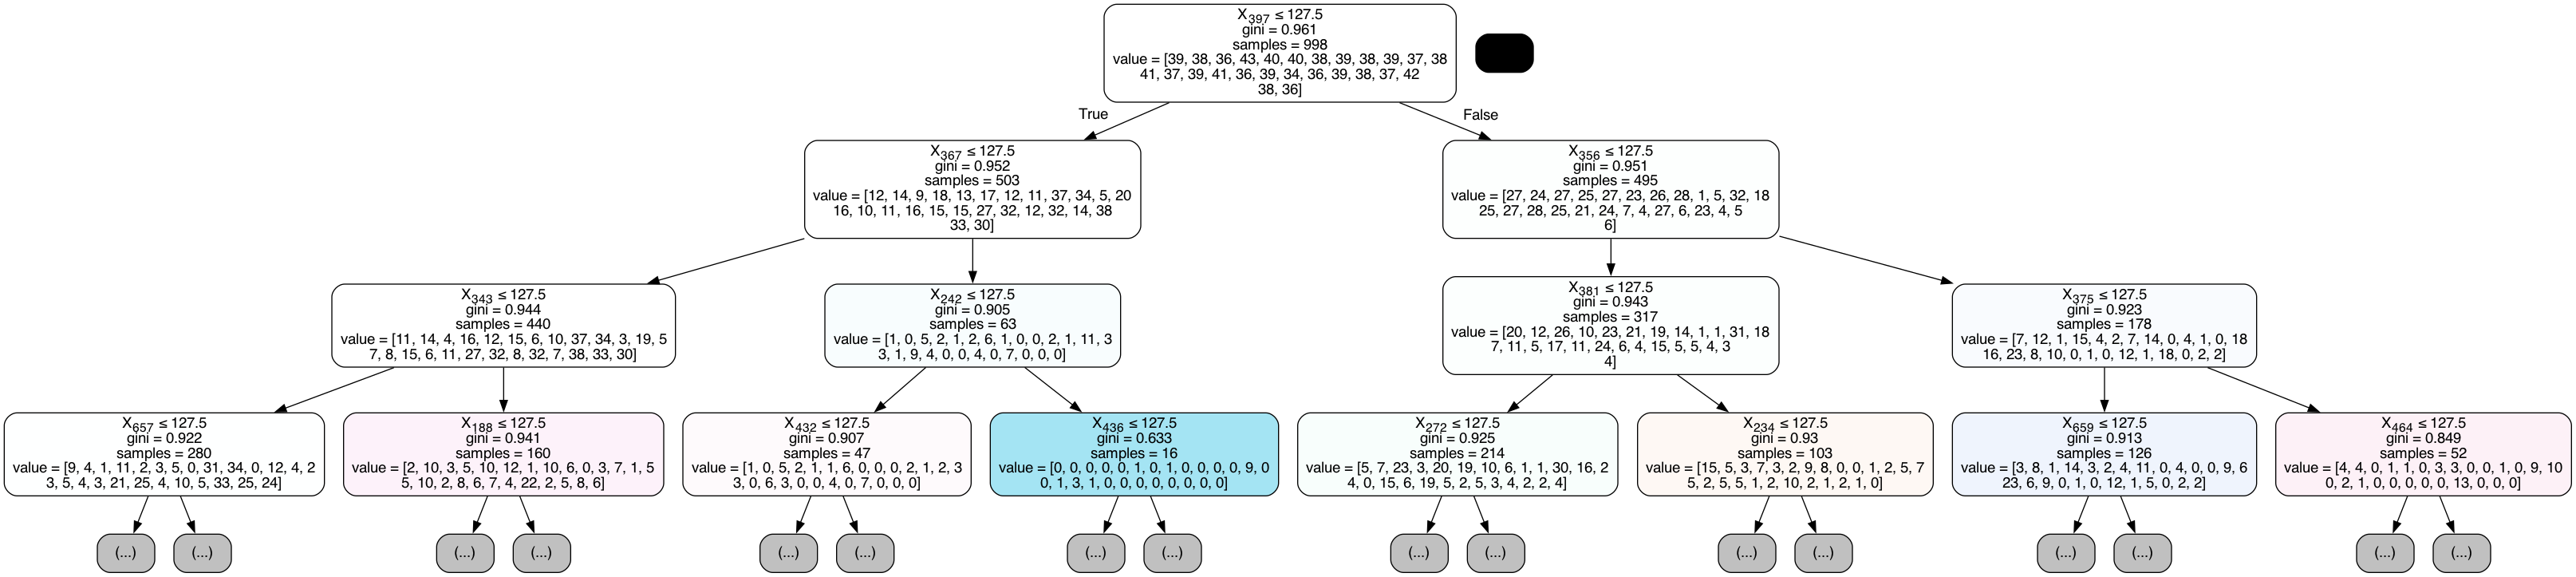

In [13]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"/lib/graphviz"
# Convert Decision Tree to visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

# graph.write_png("mnist_decision_tree_baseline.png")

Combined Data Tree

In [14]:
combined_train_data = np.concatenate((collected_train_data,train_data))
combined_train_label = np.concatenate((collected_train_label, train_label))

combined_test_data = np.concatenate((collected_test_data,test_data))
combined_test_label = np.concatenate((collected_test_label, test_label))

seed = 117
clf = DecisionTreeClassifier(max_depth=20, random_state=seed)
clf.fit(combined_train_data, combined_train_label)

train_preds_combo = clf.predict(combined_train_data)
val_preds_combo = clf.predict(combined_test_data)
acc_combo_train = acc(train_preds_combo, combined_train_label)
acc_combo_val = acc(val_preds_combo, combined_test_label)
print(f'Training accuracy for our combination: {acc_combo_train}%')
print(f'Validation accuracy for our combination: {acc_combo_val}%')

Training accuracy for our combination: 97.52%
Validation accuracy for our combination: 70.66%


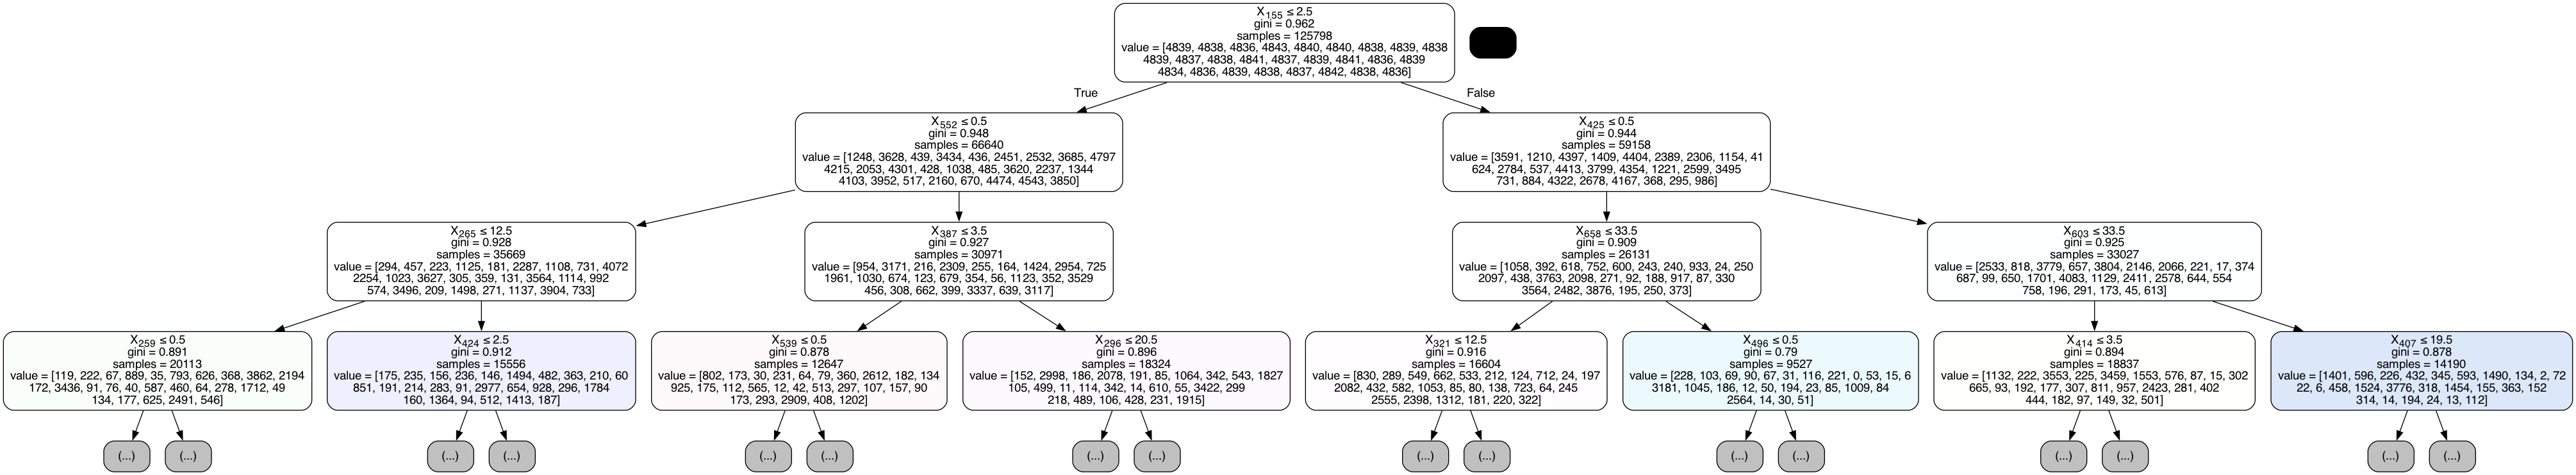

In [15]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"/lib/graphviz"
# Convert Decision Tree to visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

# graph.write_png("combo_decision_tree_baseline.png")

t-sne Tree

In [16]:
combined_data = np.concatenate((combined_train_data, combined_test_data))
combined_label = np.concatenate((combined_train_label, combined_test_label))

In [17]:
tsvd = TruncatedSVD(n_components=50).fit_transform(combined_data)
tsne = TSNE(learning_rate = 'auto', init = 'random')
transformed = tsne.fit_transform(tsvd)

In [18]:
tsne_train = pd.DataFrame(transformed[:len(combined_train_data)], columns=['component1', 'component2'])
tsne_test = pd.DataFrame(transformed[len(combined_train_data):], columns=['component1', 'component2'])
tsne_train_label = combined_label[:len(combined_train_label)]
tsne_test_label = combined_label[len(combined_train_label):]

In [19]:
clf = DecisionTreeClassifier(max_depth=20, random_state=seed)
clf.fit(tsne_train, tsne_train_label)

train_preds_tsne = clf.predict(tsne_train)
val_preds_tsne = clf.predict(tsne_test)
acc_tsne_train = acc(train_preds_tsne, tsne_train_label)
acc_tsne_val = acc(val_preds_tsne, tsne_test_label)
print(f'Training accuracy for our tsne model: {acc_tsne_train}%')
print(f'Validation accuracy for our tsne model: {acc_tsne_val}%')

Training accuracy for our tsne model: 95.68%
Validation accuracy for our tsne model: 84.5%


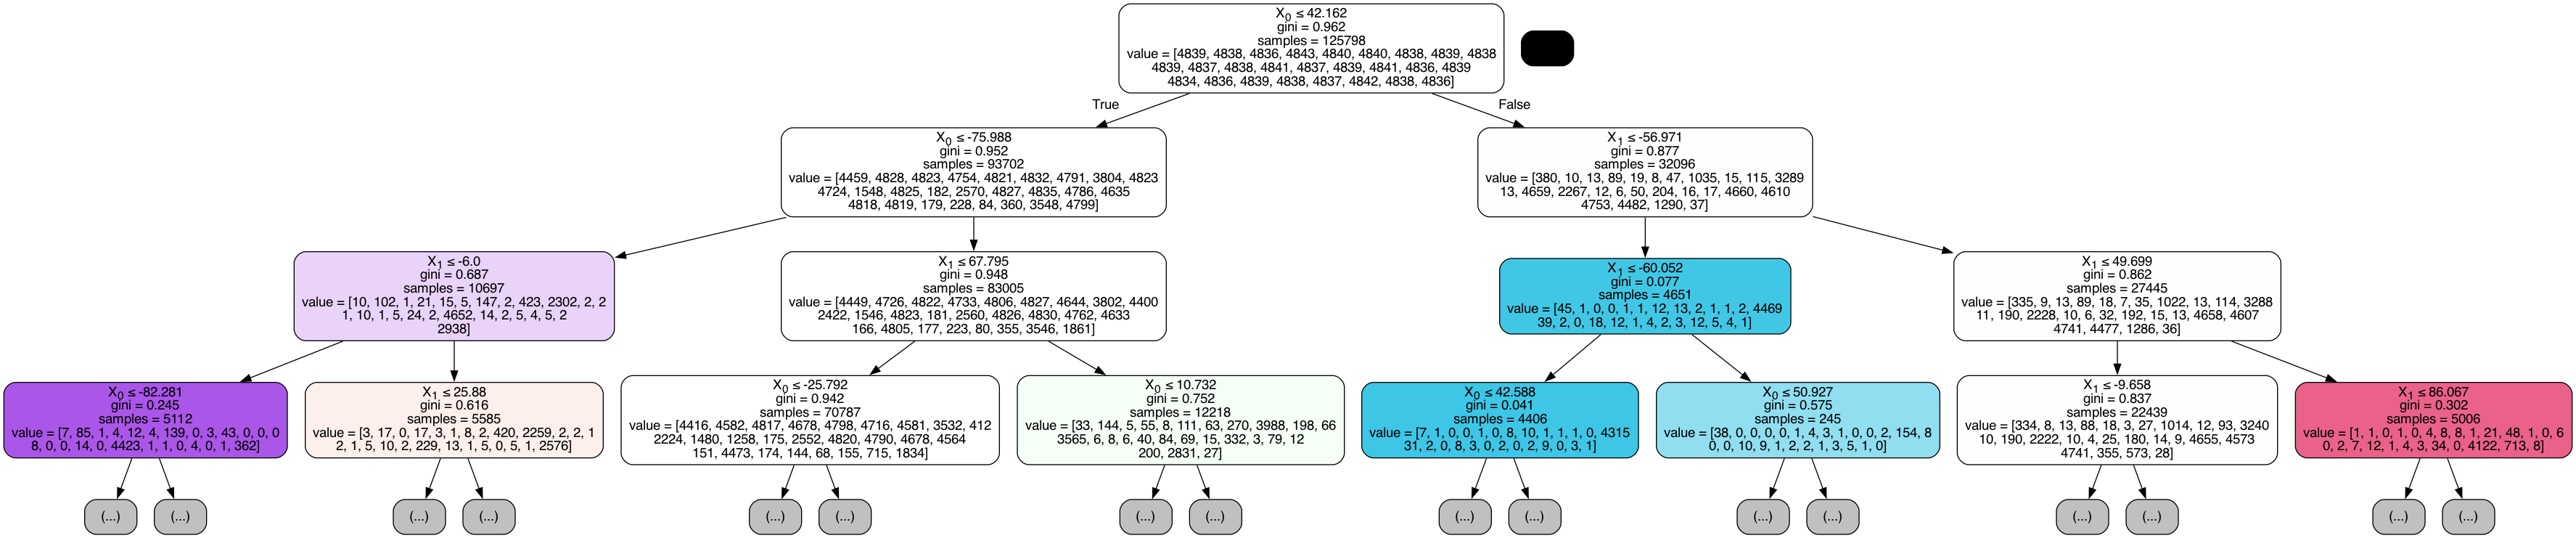

In [20]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"/lib/graphviz"
# Convert Decision Tree to visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

# graph.write_png("tsne_decision_tree_baseline.png")

### Naive Bayes

In [21]:
# Standard imports
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from skimage.transform import pyramid_gaussian

In [22]:
def draw_confusionmatrix(ytest, yhat):
    plt.figure(figsize=(10,7))
    cm = confusion_matrix(ytest, yhat)
    ax = sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    acc = accuracy_score(ytest, yhat)
    print(f"Sum Axis-1 as Classification accuracy: {(acc * 100).round(2)}%")

Base MNIST Naive Bayes

Sum Axis-1 as Classification accuracy: 34.96%


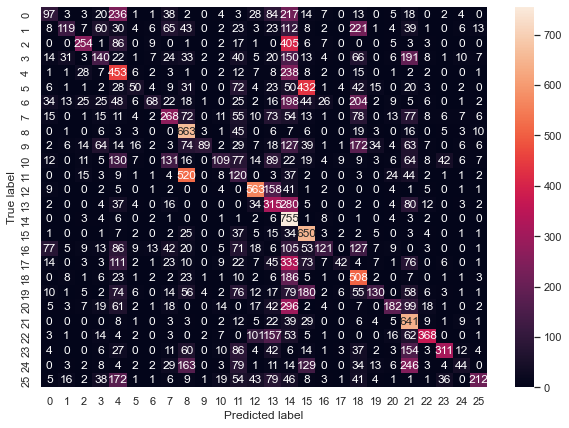

In [23]:
X = train_data
Y = train_label
X_val = test_data
Y_val = test_label

model = GaussianNB()
model.fit(X, Y)
Y_pred = model.predict(X_val)

draw_confusionmatrix(Y_val, Y_pred)

Collected Data Naive Bayes

Sum Axis-1 as Classification accuracy: 16.4%


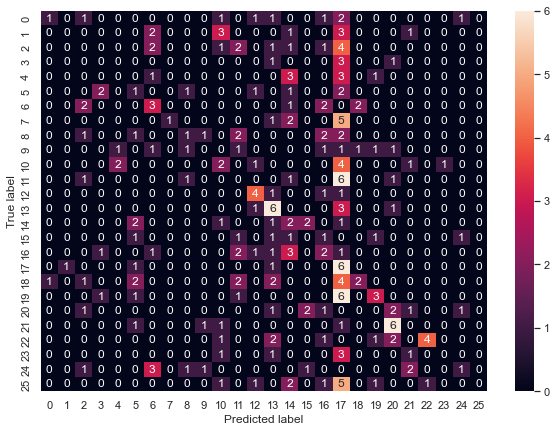

In [24]:
X_collected = collected_train_data
Y_collected = collected_train_label
X_val_collected = collected_test_data
Y_val_collected = collected_test_label

model = GaussianNB()
model.fit(X_collected, Y_collected)
Y_pred = model.predict(X_val_collected)

draw_confusionmatrix(Y_val_collected, Y_pred)

Combined Data Naive Bayes

Sum Axis-1 as Classification accuracy: 33.28%


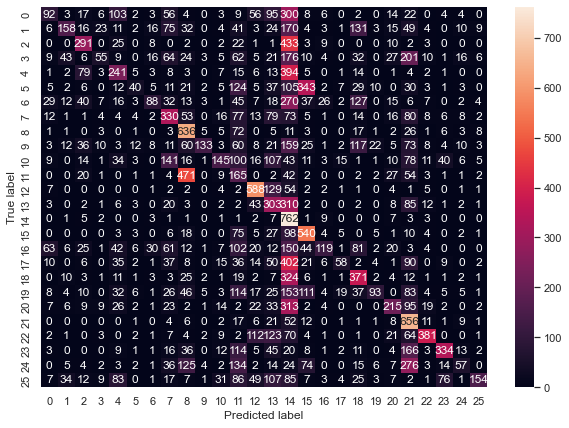

In [25]:
combined_train_data = np.concatenate((collected_train_data,train_data))
combined_train_label = np.concatenate((collected_train_label, train_label))

combined_test_data = np.concatenate((collected_test_data,test_data))
combined_test_label = np.concatenate((collected_test_label, test_label))

model = GaussianNB()
model.fit(combined_train_data, combined_train_label)
Y_pred = model.predict(combined_test_data)

draw_confusionmatrix(combined_test_label, Y_pred)

### K-Nearest Neighbors

In [26]:
# Performing K-nearest neighbors on official EMNIST data
raw_train = read_idx("EMNISTdata/emnist-letters-train-images-idx3-ubyte")
train_data = np.reshape(raw_train, (124800,28*28))
train_label = read_idx("EMNISTdata/emnist-letters-train-labels-idx1-ubyte")

raw_test = read_idx("EMNISTdata/emnist-letters-test-images-idx3-ubyte")
test_data = np.reshape(raw_test, (20800, 28*28))
test_label = read_idx("EMNISTdata/emnist-letters-test-labels-idx1-ubyte")

In [27]:
# Fitting a new classifier
X = train_data
Y = train_label

knn = neighbors.KNeighborsClassifier(n_neighbors = 10).fit(X,Y)

In [28]:
# Getting actual predictions
x_test = test_data
y_true = test_label
y_pred = knn.predict(x_test)

In [29]:
print(f"Final accuracy for raw EMNIST letters data is: {100*(y_true == y_pred).sum() / len(y_true)}%")

Final accuracy for raw EMNIST letters data is: 85.96634615384616%


In [30]:
# Now performing K-nearest-neighbors on our collected data
collected_raw_train = read_idx("convert_MNIST/train-images-idx3-ubyte")
collected_train_data = np.reshape(collected_raw_train, (998,28*28))
collected_train_label = read_idx("convert_MNIST/train-labels-idx1-ubyte")

collected_raw_test = read_idx("convert_MNIST/t10k-images-idx3-ubyte")
collected_test_data = np.reshape(collected_raw_test, (250,28*28))
collected_test_label = read_idx("convert_MNIST/t10k-labels-idx1-ubyte")

In [31]:
# Fitting a new classifier
X = collected_train_data
Y = collected_train_label

knn = neighbors.KNeighborsClassifier(n_neighbors = 10).fit(X,Y)

In [32]:
# Getting actual predictions
x_test = collected_test_data
y_true = collected_test_label
y_pred = knn.predict(x_test)

In [33]:
print(f"Final accuracy for collected handwriting data is: {100*(y_true == y_pred).sum() / len(y_true)}%")

Final accuracy for collected handwriting data is: 32.4%


In [34]:
# Combining the two datasets together and running K-nearest neighbors
combined_train_data = np.concatenate((collected_train_data,train_data))
combined_train_label = np.concatenate((collected_train_label, train_label))

combined_test_data = np.concatenate((collected_test_data,test_data))
combined_test_label = np.concatenate((collected_test_label, test_label))

In [35]:
# Fitting a new classifier
X = combined_train_data
Y = combined_train_label

knn = neighbors.KNeighborsClassifier(n_neighbors = 10).fit(X,Y)

In [36]:
# Getting actual predictions
x_test = combined_test_data
y_true = combined_test_label
y_pred = knn.predict(x_test)

In [37]:
print(f"Final accuracy for combined data is: {100*(y_true == y_pred).sum() / len(y_true)}%")

Final accuracy for combined data is: 85.04513064133016%


### SVM

In [38]:
linear_svm = SVC(kernel='linear')
linear_svm.fit(collected_train_data, collected_train_label)

y_pred = linear_svm.predict(collected_test_data)

print("Accuracy:", 100*metrics.accuracy_score(y_true=collected_test_label, y_pred=y_pred), "%")

print(metrics.confusion_matrix(y_true=collected_test_label, y_pred=y_pred))

Accuracy: 40.400000000000006 %
[[3 0 0 0 0 0 0 0 0 0 0 0 2 0 3 0 0 0 0 0 0 0 0 0 0 1]
 [1 5 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 5 0 1 0 0 0 0 0 0 1 1 0 0 0 0 2 0 0 1 0 0 1 0 0]
 [3 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 1 0 0 1 0 2 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1]
 [0 2 0 0 0 0 6 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 2 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 1 0 1 0 0 0 0 0 0 0 2 0 0 0 1 0 1]
 [0 0 0 1 0 0 0 0 3 4 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0]
 [0 0 4 0 0 0 0 0 2 0 0 3 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 0 1 0 0 0 2 0 0 0 0 0 3 0 0 0 0 0 0 2 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 3 1 0 0 0 0]
 [0 0 0 0 1 2 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 7 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 

Now testing a grid search to comb through and fine tune our hyper parameters to determine the best model for our collected handwritten data.

In [39]:
param_grid = [{'gamma': [1e-2, 1e-3, 1e-4],'C': [1,5,10]}]

model = SVC(kernel="rbf")

grid = GridSearchCV(estimator = model, param_grid = param_grid)      

# fit the model
grid.fit(collected_train_data, collected_train_label)

print("Accuracy: ", 100*grid.best_score_, "%")
print("Params: ", grid.best_params_)

y_pred = grid.predict(collected_test_data)
print("Test accuracy: ", 100*metrics.accuracy_score(collected_test_label, y_pred),"%")
print(metrics.confusion_matrix(collected_test_label, y_pred))

Accuracy:  5.31005025125628 %
Params:  {'C': 1, 'gamma': 0.0001}
Test accuracy:  2.0 %
[[ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]


Finally, by using the hyperparameters from our previous grid search and applying them to the combined dataset of both EMNIST and Handwritten Data.

In [40]:
y_pred = grid.predict(combined_test_data)
print("Test accuracy: ", 100*metrics.accuracy_score(combined_test_label, y_pred), "%")
print(metrics.confusion_matrix(combined_test_label, y_pred))

Test accuracy:  3.8242280285035632 %
[[  0   0   0 809   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 810   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 812   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 805   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 808   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 808   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 810   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 809   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  0   0   0 810   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0

### K-Means Clustering



In [41]:
# When we use K-Means Clustering, we will not be able to identify which cluster represents 
# which letter of the alphabet. By using this method, we are able to match these clusters with the
# most probable letter
def retrieve_info(cluster_labels,y_train):
    reference_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [42]:
#Train model on EMNIST Data
cur_high_score = -1
cur_high_cluster = -1
best_kmeans_org = None
for k in [10,16,36,64,144,256]:
    kmeans = cluster.KMeans(n_clusters=k).fit(train_data)
    ref = retrieve_info(kmeans.labels_, train_label)
    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
 
        number_labels[i] = ref[kmeans.labels_[i]]
 
    print('Accuracy score : {}'.format(accuracy_score(number_labels,train_label)))
    if accuracy_score(number_labels,train_label) > cur_high_score:
        cur_high_score = accuracy_score(number_labels,train_label)
        cur_high_cluster = k
        best_kmeans_org = kmeans
        print('New Best Cluster: ', k)
        print('New Best Score: ', accuracy_score(number_labels,train_label))


Accuracy score : 0.22786057692307693
New Best Cluster:  10
New Best Score:  0.22786057692307693
Accuracy score : 0.31053685897435895
New Best Cluster:  16
New Best Score:  0.31053685897435895
Accuracy score : 0.4539423076923077
New Best Cluster:  36
New Best Score:  0.4539423076923077
Accuracy score : 0.4329917992978123
Accuracy score : 0.4333302930189381
Accuracy score : 0.4439103799100023


In [43]:
#Train model on Handwritten Data
cur_high_score = -1
cur_high_cluster = -1
best_kmeans_collected = None
for k in [10,16,36,64,144,256]:
    kmeans = cluster.KMeans(n_clusters=k).fit(collected_train_data)
    ref = retrieve_info(kmeans.labels_, collected_train_label)
    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
 
        number_labels[i] = ref[kmeans.labels_[i]]
 
    print('Accuracy score : {}'.format(accuracy_score(number_labels,collected_train_label)))
    if accuracy_score(number_labels,collected_train_label) > cur_high_score:
        cur_high_score = accuracy_score(number_labels,collected_train_label)
        cur_high_cluster = k
        best_kmeans_collected = kmeans
        print('New Best Cluster: ', k)
        print('New Best Score: ', accuracy_score(number_labels,collected_train_label))

Accuracy score : 0.1743486973947896
New Best Cluster:  10
New Best Score:  0.1743486973947896
Accuracy score : 0.21442885771543085
New Best Cluster:  16
New Best Score:  0.21442885771543085
Accuracy score : 0.281563126252505
New Best Cluster:  36
New Best Score:  0.281563126252505
Accuracy score : 0.3256513026052104
New Best Cluster:  64
New Best Score:  0.3256513026052104
Accuracy score : 0.4288577154308617
New Best Cluster:  144
New Best Score:  0.4288577154308617
Accuracy score : 0.5420841683366734
New Best Cluster:  256
New Best Score:  0.5420841683366734


In [44]:
#Train model on both EMNIST and Handwritten Data
cur_high_score = -1
cur_high_cluster = -1
best_kmeans_combined = None
for k in [10,16,36,64,144,256]:
    kmeans = cluster.KMeans(n_clusters=k).fit(combined_train_data)
    ref = retrieve_info(kmeans.labels_, combined_train_label)
    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
 
        number_labels[i] = ref[kmeans.labels_[i]]
 
    print('Accuracy score : {}'.format(accuracy_score(number_labels,combined_train_label)))
    if accuracy_score(number_labels,combined_train_label) > cur_high_score:
        cur_high_score = accuracy_score(number_labels,combined_train_label)
        cur_high_cluster = k
        best_kmeans_combined = kmeans
        print('New Best Cluster: ', k)
        print('New Best Score: ', accuracy_score(number_labels,combined_train_label))

Accuracy score : 0.22629135598340197
New Best Cluster:  10
New Best Score:  0.22629135598340197
Accuracy score : 0.30983799424474157
New Best Cluster:  16
New Best Score:  0.30983799424474157
Accuracy score : 0.4476541757420627
New Best Cluster:  36
New Best Score:  0.4476541757420627
Accuracy score : 0.5089906039841651
New Best Cluster:  64
New Best Score:  0.5089906039841651
Accuracy score : 0.5864004197205043
New Best Cluster:  144
New Best Score:  0.5864004197205043
Accuracy score : 0.6405745719327811
New Best Cluster:  256
New Best Score:  0.6405745719327811


Now using the model trained on both the handwritten and EMNIST data and test against a combined version of handwritten and EMNIST data

In [45]:
best_kmeans_org = pickle.load(open("best_kmeans_org.sav", 'rb'))

In [46]:
best_kmeans_collected = pickle.load(open("best_kmeans_collected.sav", 'rb'))

In [47]:
best_kmeans_combined = pickle.load(open("best_kmeans_combined.sav", 'rb'))

In [48]:
#Test how a model trained on ONLY EMNIST DATA does against EMNIST DATA
kmeans = best_kmeans_org
ref = retrieve_info(kmeans.labels_, train_label)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = ref[kmeans.labels_[i]]
print('Accuracy score for a model trained on ONLY EMNIST DATA against EMNIST DATA:')
print(100*(accuracy_score(number_labels,train_label)),"%")

#Test how a model trained on ONLY HANDWRITTEN DATA does against HANDWRITTEN DATA
kmeans = best_kmeans_collected
ref = retrieve_info(kmeans.labels_, collected_train_label)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = ref[kmeans.labels_[i]]
print('Accuracy score for a model trained on ONLY HANDWRITTEN DATA against HANDWRITTEN DATA:')
print(100*(accuracy_score(number_labels,collected_train_label)),"%")

#Test how a model trained on BOTH EMNIST AND HANDWRITTEN DATA does against BOTH EMNIST AND HANDWRITTEN DATA
kmeans = best_kmeans_combined
ref = retrieve_info(kmeans.labels_, combined_train_label)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = ref[kmeans.labels_[i]]
print('Accuracy score for a model trained on BOTH EMNIST AND HANDWRITTEN DATA against BOTH EMNIST AND HANDWRITTEN DATA:')
print(100*(accuracy_score(number_labels,combined_train_label)),"%")

### Neural Network

In [49]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

In [50]:
# Function to one-hot encode the labels that we have
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

In [51]:
# Read in the EMNIST letters data
raw_train = read_idx("EMNISTdata/emnist-letters-train-images-idx3-ubyte")
train_data = np.reshape(raw_train, (124800,28*28))
train_label = read_idx("EMNISTdata/emnist-letters-train-labels-idx1-ubyte")

raw_test = read_idx("EMNISTdata/emnist-letters-test-images-idx3-ubyte")
test_data = np.reshape(raw_test, (20800, 28*28))
test_label = read_idx("EMNISTdata/emnist-letters-test-labels-idx1-ubyte")

In [52]:
# Show us how many classes we have
print(set(train_label))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


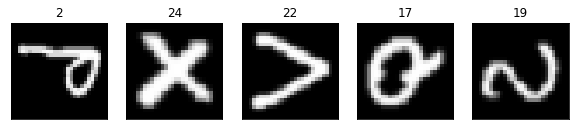

In [53]:
# Displaying 5 random inputs from the dataset (visualization)
fig, axes = plt.subplots(ncols=5,sharex=False,sharey=True,figsize=(10,4))
import random as rd
for i in range(5):
    index = rd.randint(0,len(train_label))
    axes[i].set_title(train_label[index])
    axes[i].imshow(raw_train[index], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

In [54]:
# One hot encoding the features of our collected data
# Here, we have 27 classes (lowercase and upper case are batched as 1)
y_train = one_hot(train_label,27)
y_test = one_hot(test_label,27)

print(y_train.shape)
print(y_test.shape)

(124800, 27)
(20800, 27)


In [55]:
# Simple MLP network with 12 epochs (max) and 500 neurons in a hidden layer
mlp = MLPClassifier(
    hidden_layer_sizes=(500,),
    max_iter=12,
    alpha=1e-4,
    solver="adam",
    verbose=True,
    random_state=1,
    learning_rate="adaptive"
)

In [56]:
# Training loop (ignoring warnings for decluttered output)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(train_data, y_train)

Iteration 1, loss = 9.91315094
Iteration 2, loss = 2.43090610
Iteration 3, loss = 1.39249526
Iteration 4, loss = 1.07801807
Iteration 5, loss = 0.95006058
Iteration 6, loss = 0.89275646
Iteration 7, loss = 0.86221655
Iteration 8, loss = 0.84753245
Iteration 9, loss = 0.84542920
Iteration 10, loss = 0.82907062
Iteration 11, loss = 0.83320660
Iteration 12, loss = 0.81929866


In [57]:
print(f"EMNIST Letters training set accuray: {100*mlp.score(train_data, y_train)}%")
print(f"EMNIST Letters test set accuracy: {100*mlp.score(test_data, y_test)}%")

EMNIST Letters training set accuray: 79.53365384615385%
EMNIST Letters test set accuracy: 75.94711538461539%


In [58]:
# Reading in the collected training data
collected_raw_train = read_idx("convert_MNIST/train-images-idx3-ubyte")
collected_train_data = np.reshape(collected_raw_train, (998,28*28))
collected_train_label = read_idx("convert_MNIST/train-labels-idx1-ubyte")

collected_raw_test = read_idx("convert_MNIST/t10k-images-idx3-ubyte")
collected_test_data = np.reshape(collected_raw_test, (250,28*28))
collected_test_label = read_idx("convert_MNIST/t10k-labels-idx1-ubyte")

In [59]:
# Show us how many classes we have
print(set(collected_train_label))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


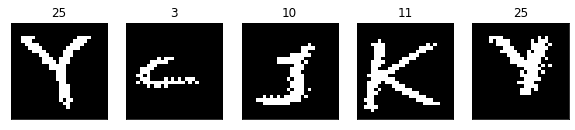

In [60]:
# Displaying 5 random inputs from the collected dataset (visualization)
fig, axes = plt.subplots(ncols=5,sharex=False,sharey=True,figsize=(10,4))
import random as rd
for i in range(5):
    index = rd.randint(0,len(collected_train_label))
    axes[i].set_title(collected_train_label[index])
    axes[i].imshow(collected_raw_train[index], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

In [61]:
# One hot encoding the features of our collected data
# Here, we have 52 classes (lowercase and upper case are batched as 1)
y_train = one_hot(collected_train_label,27)
y_test = one_hot(collected_test_label,27)

print(y_train.shape)
print(y_test.shape)

(998, 27)
(250, 27)


In [62]:
# Simple MLP network with 12 epochs (max) and 500 neurons in a hidden layer
mlp = MLPClassifier(
    hidden_layer_sizes=(500,),
    max_iter=12,
    alpha=1e-4,
    solver="adam",
    verbose=True,
    random_state=1,
    learning_rate="adaptive"
)

In [63]:
# Training loop (ignoring warnings for decluttered output)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(collected_train_data, y_train)

Iteration 1, loss = 143.77364033
Iteration 2, loss = 37.98360730
Iteration 3, loss = 37.94360809
Iteration 4, loss = 32.93942701
Iteration 5, loss = 25.47036326
Iteration 6, loss = 21.10115834
Iteration 7, loss = 15.37274088
Iteration 8, loss = 10.98961976
Iteration 9, loss = 7.13809851
Iteration 10, loss = 4.50219446
Iteration 11, loss = 2.94808569
Iteration 12, loss = 1.64546503


In [64]:
print(f"Collected training set accuray: {100*mlp.score(collected_train_data, y_train)}%")
print(f"Collected test set accuracy: {100*mlp.score(collected_test_data, y_test)}%")

Collected training set accuray: 91.28256513026052%
Collected test set accuracy: 13.200000000000001%


In [65]:
# Combining the two datasets together and running new MLP classifier
combined_raw_train_data = np.concatenate((collected_raw_train, raw_train))
combined_train_data = np.concatenate((collected_train_data,train_data))
combined_train_label = np.concatenate((collected_train_label, train_label))

combined_test_data = np.concatenate((collected_test_data,test_data))
combined_test_label = np.concatenate((collected_test_label, test_label))

In [66]:
# Show us how many classes we have
print(set(combined_train_label))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


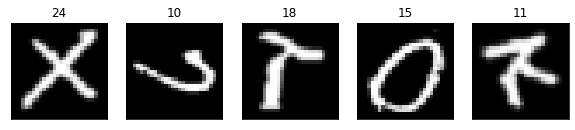

In [67]:
# Displaying 5 random inputs from the collected dataset (visualization)
fig, axes = plt.subplots(ncols=5,sharex=False,sharey=True,figsize=(10,4))
import random as rd
for i in range(5):
    index = rd.randint(0,len(combined_train_label))
    axes[i].set_title(combined_train_label[index])
    axes[i].imshow(combined_raw_train_data[index], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

In [68]:
# One hot encoding the features of our collected data
# Here, we have 52 classes (lowercase and upper case are batched as 1)
y_train = one_hot(combined_train_label,27)
y_test = one_hot(combined_test_label,27)

print(y_train.shape)
print(y_test.shape)

(125798, 27)
(21050, 27)


In [69]:
# Simple MLP network with 12 epochs (max) and 500 neurons in a hidden layer
mlp = MLPClassifier(
    hidden_layer_sizes=(500,),
    max_iter=12,
    alpha=1e-4,
    solver="adam",
    verbose=True,
    random_state=1,
    learning_rate="adaptive"
)

In [70]:
# Training loop (ignoring warnings for decluttered output)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(combined_train_data, y_train)

Iteration 1, loss = 9.84941208
Iteration 2, loss = 2.34327801
Iteration 3, loss = 1.41168336
Iteration 4, loss = 1.13122865
Iteration 5, loss = 1.01089413
Iteration 6, loss = 0.95018811
Iteration 7, loss = 0.91938232
Iteration 8, loss = 0.90397632
Iteration 9, loss = 0.89061719
Iteration 10, loss = 0.88676019
Iteration 11, loss = 0.86730365
Iteration 12, loss = 0.85655183


In [71]:
print(f"Combined training set accuray: {100*mlp.score(combined_train_data, y_train)}%")
print(f"Combined test set accuracy: {100*mlp.score(combined_test_data, y_test)}%")

Combined training set accuray: 78.30808120955818%
Combined test set accuracy: 74.4750593824228%


### Ensemble Learning

##### Using the data from the official ENMIST dataset:

In [72]:
raw_train = read_idx("EMNISTdata/emnist-letters-train-images-idx3-ubyte")
train_data = np.reshape(raw_train, (124800,28*28))
train_label = read_idx("EMNISTdata/emnist-letters-train-labels-idx1-ubyte")

raw_test = read_idx("EMNISTdata/emnist-letters-test-images-idx3-ubyte")
test_data = np.reshape(raw_test, (20800, 28*28))
test_label = read_idx("EMNISTdata/emnist-letters-test-labels-idx1-ubyte")

Training the Random Foreset, K-Nearest Neighbor, and Extra Trees:

In [73]:
X = train_data
Y = train_label
X_test = test_data
Y_test = test_label

rfc = ensemble.RandomForestClassifier().fit(X,Y)
y_pred = rfc.predict(X_test)
acc = (Y_test == y_pred).sum() / len(Y_test)
print("Accuracy of using Random Forest Classifer: ", acc*100, "%")

knnc = neighbors.KNeighborsClassifier(n_neighbors=10).fit(X,Y)

extc = ensemble.ExtraTreesClassifier().fit(X,Y)

Accuracy of using Random Forest Classifer:  88.66346153846155 %


Combining all algorithms in an ensemble voting classifier:

In [74]:
estimators = [("knn", knnc), ("rf", rfc), ("ext", extc)]
vc = ensemble.VotingClassifier(estimators, voting="hard")
vc.fit(X,Y)
acc = vc.score(X_test, Y_test)
print("Accuracy of using Voting Classifier: ", acc*100, "%")

Accuracy of using Voting Classifier:  89.08173076923077 %


###### Using the handwriting data we collected:

In [75]:
collected_raw_train = read_idx("convert_MNIST/train-images-idx3-ubyte")
collected_train_data = np.reshape(collected_raw_train, (998,28*28))
collected_train_label = read_idx("convert_MNIST/train-labels-idx1-ubyte")

collected_raw_test = read_idx("convert_MNIST/t10k-images-idx3-ubyte")
collected_test_data = np.reshape(collected_raw_test, (250,28*28))
collected_test_label = read_idx("convert_MNIST/t10k-labels-idx1-ubyte")

Training the Random Forest, K-Nearest Neighbor, and Extra Trees:

In [76]:
X = collected_train_data
Y = collected_train_label
X_test = collected_test_data
Y_test = collected_test_label

rfc = ensemble.RandomForestClassifier().fit(X,Y)
y_pred = rfc.predict(X_test)
acc = (Y_test == y_pred).sum() / len(Y_test)
print("Accuracy of using Random Forest Classifer: ", acc*100, "%")

knnc = neighbors.KNeighborsClassifier(n_neighbors=10).fit(X,Y)

extc = ensemble.ExtraTreesClassifier().fit(X,Y)

Accuracy of using Random Forest Classifer:  38.800000000000004 %


Combining all algorithms in an ensemble voting classifier:

In [77]:
estimators = [("knn", knnc), ("rf", rfc), ("ext", extc)]
vc = ensemble.VotingClassifier(estimators, voting="hard")
vc.fit(X,Y)
acc = vc.score(X_test, Y_test)
print("Accuracy of using Voting Classifier: ", acc*100, "%")

Accuracy of using Voting Classifier:  40.0 %


##### Combining the handwritten and EMNIST data:

In [78]:
combined_train_data = np.concatenate((collected_train_data,train_data))
combined_train_label = np.concatenate((collected_train_label, train_label))

combined_test_data = np.concatenate((collected_test_data,test_data))
combined_test_label = np.concatenate((collected_test_label, test_label))

Training the Random Forest, K-Nearest Neighbor, and Extra Trees:

In [79]:
X = combined_train_data
Y = combined_train_label
X_test = combined_test_data
Y_test = combined_test_label

rfc = ensemble.RandomForestClassifier().fit(X,Y)
y_pred = rfc.predict(X_test)
acc = (Y_test == y_pred).sum() / len(Y_test)
print("Accuracy of using Random Forest Classifer: ", acc*100, "%")

knnc = neighbors.KNeighborsClassifier(n_neighbors=10).fit(X,Y)

extc = ensemble.ExtraTreesClassifier().fit(X,Y)

Accuracy of using Random Forest Classifer:  87.61995249406176 %


Combining all algorithms into ensemble voting classifier:

In [80]:
estimators = [("knn", knnc), ("rf", rfc), ("ext", extc)]
vc = ensemble.VotingClassifier(estimators, voting="hard")
vc.fit(X,Y)
acc = vc.score(X_test, Y_test)
print("Accuracy of using Voting Classifier: ", acc*100, "%")

Accuracy of using Voting Classifier:  88.12826603325415 %
